In [1]:
import numpy as np
import h5py
import netCDF4 as nc
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal
import warnings

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

plt.rc('font', size=12)
h, f_noise, clrs = odas.all_line_info()

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def calc_cf(das,dasTime,press,presTime,t1,numvals):
    frq, psd_strain = signal.welch(das[(dasTime>t1) & (dasTime<(t1+numvals))], fs=2, window='hann', nperseg=fs*60*5)
    frqP, psd_press = signal.welch(press[(presTime>t1) & (presTime<(t1+numvals))], fs=2, window='hann', nperseg=fs*60*5)   
    psd_press = np.interp(frq,frqP,psd_press)
    strain_fac = psd_press/psd_strain
    return frq, strain_fac

def calc_waves(das,dasTime,press,presTime,test_time,numvals,strainFac,frq,depth,f_cutoff):
    L = len(test_time)
    Te_Das = np.empty([L])*np.nan
    Hs_Das = np.empty([L])*np.nan
    Te_Pre = np.empty([L])*np.nan
    Hs_Pre = np.empty([L])*np.nan
    for jj in range(L):
        temp = das[(dasTime>test_time[jj]) & (dasTime<(test_time[jj]+numvals))]
        _, Te_Das[jj], Hs_Das[jj] = odas.DAS_wave_conversion(temp,2,depth,strainFac,frq,f_cutoff)
        temp = press[(presTime>test_time[jj]) & (presTime<(test_time[jj]+numvals))]
        _, Te_Pre[jj], Hs_Pre[jj] = odas.pres_wave_conversion(temp,2,depth)
    Te_Das[Te_Das>20] = 20

    # calculate rmse for hs and te
    rms_te = np.sqrt(np.mean((Te_Das-Te_Pre)**2))
    rms_hs = np.sqrt(np.mean((Hs_Das-Hs_Pre)**2))
    
    return rms_te,rms_hs

def calc_waves_hom(das,dasTime,test_time,numvals,strainFac,frq,depth,f_cutoff):
    L = len(test_time)
    Te_Das = np.empty([L])*np.nan
    Hs_Das = np.empty([L])*np.nan
    
    for jj in range(L):
        temp = das[(dasTime>test_time[jj]) & (dasTime<(test_time[jj]+numvals))]
        _, Te_Das[jj], Hs_Das[jj] = odas.DAS_wave_conversion(temp,2,depth,strainFac,frq,f_cutoff)
    Te_Das[Te_Das>20] = 20

    return Te_Das, Hs_Das


def calc_cf_hom(das,dasTime,sspec,sfreq,sdate,t1,numvals):
    frq, psd_strain = signal.welch(das[(dasTime>t1) & (dasTime<(t1+numvals))], fs=2.5, window='hann', nperseg=2*60*5)
    temp = sspec[(sdate>t1-1) & (sdate<t1+30),:].flatten()
    psd_press = np.interp(frq,sfreq,temp)
    strain_fac = psd_press/psd_strain
    return frq, strain_fac

In [3]:
# Duck
pname = 'DuckNC_Glover/'

# load pressure
with np.load(pname+'FRF-ocean_waveTs_awac-11m_202111.npz') as data:
    press = data['p']
    presTime = data['t']

# load strain
f = h5py.File(pname + 'ChNo436_Nov2021fromdown.hdf5', 'r') 
dasTime = f['Acquisition']['RawDataTime'][:]
das = f['Acquisition']['RawData'][:] # unit of E
fs = 2 # this is downsampled data at 2Hz
h = 11 # load approx water depth for channel location

# set training data periods
numvals = 60*60
t1 = datetime(2021, 11, 11, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2021, 11, 24, 0, 0, 0,tzinfo=timezone.utc).timestamp()
train_time = np.arange(t1,t2,numvals)
L_train = len(train_time)
# Calculate strain factor for each point in the interval
frq, strain_fac = calc_cf(das,dasTime,press,presTime,t1,numvals)                                          
for jj in range(1,L_train):
    _, temp = calc_cf(das,dasTime,press,presTime,train_time[jj],numvals)
    strain_fac = np.vstack([strain_fac,temp])

sf_cum = strain_fac[0,:]
for jj in range(1,L_train):
    temp = np.nanmedian(strain_fac[:jj,:],axis=0)
    sf_cum = np.vstack([sf_cum,temp])



# now calculate for the testing period for each                                         
t1 = datetime(2021, 11, 18, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2021, 11, 20, 0, 0, 0,tzinfo=timezone.utc).timestamp()
test_time = np.arange(t1,t2,numvals)

rms_te_duck = np.empty(L_train)*np.nan
rms_hs_duck = np.empty(L_train)*np.nan

for jj in range(L_train):
    C = sf_cum[jj,:]
    rms_te_duck[jj], rms_hs_duck[jj] = calc_waves(das,dasTime,press,presTime,test_time,numvals,C,frq,h,f_noise[0])

rms_te_duck = np.sort(rms_te_duck)[::-1]
rms_hs_duck = np.sort(rms_hs_duck)[::-1]
days_duck = np.arange(0,L_train)


In [4]:
# KNO
pname = 'KNO_Glover/'

# load pressure
with np.load(pname + 'rbr_pres_temp_all.npz') as data:
    press = data['p'][:,5] #5 is nearest ch124, h=11.5 m
    presTime = data['tvec']

# load strain data
with np.load(pname + 'filtstrain_F1_ch124.npz') as data:
    das = data['e']
    dasTime = data['t']
fs = 2
h = 11

# set training data periods
numvals = 60*60
t1 = datetime(2023, 1, 14, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 1, 29, 0, 0, 0,tzinfo=timezone.utc).timestamp()
train_time = np.arange(t1,t2,numvals)
L_train = len(train_time)
# Calculate strain factor for each point in the interval
frq, strain_fac = calc_cf(das,dasTime,press,presTime,t1,numvals)                                          
for jj in range(1,L_train):
    _, temp = calc_cf(das,dasTime,press,presTime,train_time[jj],numvals)
    strain_fac = np.vstack([strain_fac,temp])

sf_cum = strain_fac[0,:]
for jj in range(1,L_train):
    temp = np.nanmedian(strain_fac[:jj,:],axis=0)
    sf_cum = np.vstack([sf_cum,temp])


# now calculate for the testing period for each                                         
t1 = datetime(2023, 1, 17, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 1, 20, 0, 0, 0,tzinfo=timezone.utc).timestamp()
test_time = np.arange(t1,t2,numvals)

rms_te_kno = np.empty(L_train)*np.nan
rms_hs_kno = np.empty(L_train)*np.nan

for jj in range(L_train):
    C = sf_cum[jj,:]
    rms_te_kno[jj], rms_hs_kno[jj] = calc_waves(das,dasTime,press,presTime,test_time,numvals,C,frq,h,f_noise[1])

rms_te_kno = np.sort(rms_te_kno)[::-1]
rms_hs_kno = np.sort(rms_hs_kno)[::-1]
days_kno = np.arange(0,L_train)


In [5]:
pname = 'HomerAK_Williams/'
# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][2:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][2:,:] # m^2/Hz

# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
das,dasTime,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
das = das[~np.isnan(dasTime),31]
dasTime = dasTime[~np.isnan(dasTime)][:]
depth = depth[31]
print(datetime.utcfromtimestamp(dasTime[0]))
print(datetime.utcfromtimestamp(dasTime[-1]))

# set training data periods
numvals = 60*60
t1 = datetime(2023, 6, 10, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 6, 25, 0, 0, 0,tzinfo=timezone.utc).timestamp()
train_time = np.arange(t1,t2,numvals)
L_train = len(train_time)

# Calculate strain factor for each point in the interval
frq, strain_fac = calc_cf_hom(das,dasTime,sspec,sfreq,sdate,t1,numvals)                                          
for jj in range(1,L_train):
    _, temp = calc_cf_hom(das,dasTime,sspec,sfreq,sdate,train_time[jj],numvals)
    strain_fac = np.vstack([strain_fac,temp])

sf_cum = strain_fac[0,:]
for jj in range(1,L_train):
    temp = np.nanmedian(strain_fac[:jj,:],axis=0)
    sf_cum = np.vstack([sf_cum,temp])



# now calculate for the testing period for each                                         
t1 = datetime(2023, 6, 25, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 6, 27, 0, 20, 0,tzinfo=timezone.utc).timestamp()
test_time = np.arange(t1,t2,numvals)


# calculate wave stats from spectra for comparison:
sspec = sspec[(sdate>=t1) & (sdate<=t2),:]
sdate = sdate[(sdate>=t1) & (sdate<=t2)]
L = len(sdate)
Hs_Pre = np.zeros(L)
Te_Pre = np.zeros(L)
for jj in range(L):
    ds_psd_corr = sspec[jj,(sfreq > 0.04) & (sfreq < 0.35)]
    f_psd = sfreq[(sfreq > 0.04) & (sfreq < 0.35)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    Te_Pre[jj] = 1/fe
    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    Hs_Pre[jj] = 4*np.sqrt( ds_psd_corr.sum() * bandwidth ) 


rms_te = np.empty(L_train)*np.nan
rms_hs = np.empty(L_train)*np.nan
for jj in range(L_train):
    C = sf_cum[jj,:]
    Te_Das, Hs_Das = calc_waves_hom(das,dasTime,test_time,numvals,C,frq,44,f_noise[4])
    # calculate rmse for hs and te
    mask = np.isfinite(Te_Das) & np.isfinite(Te_Pre)
    rms_te[jj] = np.sqrt(np.mean((Te_Das[mask]-Te_Pre[mask])**2))
    mask = np.isfinite(Hs_Das) & np.isfinite(Hs_Pre)
    rms_hs[jj] = np.sqrt(np.mean((Hs_Das[mask]-Hs_Pre[mask])**2))

rms_te_hom = np.sort(rms_te)[::-1]
rms_hs_hom = np.sort(rms_hs)[::-1]
days_hom = np.arange(0,L_train)


2023-06-09 00:01:59.447200
2023-07-06 00:02:02.728000


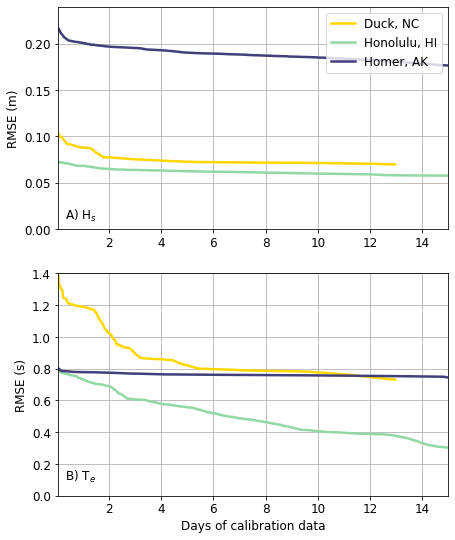

In [6]:
fig,ax = plt.subplots(2,1,figsize=(7,9))
ax[0].plot(days_duck/24,rms_hs_duck,label='Duck, NC',c = 'gold',linewidth=2.5)
ax[0].plot(days_kno/24,rms_hs_kno,label='Honolulu, HI',c = clrs[1],linewidth=2.5)
ax[0].plot(days_hom/24,rms_hs_hom,label='Homer, AK',c = clrs[4],linewidth=2.5)
# ax[0].set_xscale('log')
# ax[0].set_xlabel('Hours of calibration data')
ax[0].set_xlim([1/24,360/24])
ax[0].set_ylim([0,0.24])
ax[0].grid(which='major', axis='both')
ax[0].set_ylabel('RMSE (m)')
ax[0].legend(loc='upper right')

ax[1].plot(days_duck/24,rms_te_duck,c = 'gold',linewidth=2.5)
ax[1].plot(days_kno/24,rms_te_kno,c = clrs[1],linewidth=2.5)
ax[1].plot(days_hom/24,rms_te_hom,c = clrs[4],linewidth=2.5)
# ax[1].set_xscale('log')
ax[1].grid(which='major', axis='both')
ax[1].set_xlabel('Days of calibration data')
ax[1].set_xlim([1/24,360/24])
ax[1].set_ylim([0,1.4])
ax[1].set_ylabel('RMSE (s)')


ax[0].text(0.3,0.01, 'A) H$_s$')
ax[1].text(0.3,0.1, 'B) T$_e$')

fig.savefig('/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/writing/das_comparison/figs/F9_CalTime.pdf',dpi=200)